## Performing the classification
#### Calling all libraries

In [1]:
# %pip install -r requirements.txt

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn import tree
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tsfresh import feature_selection
from mrmr import mrmr_classif

import numpy as np
import pandas as pd     
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import lightgbm as lgb
import glob
import os
import re

#### First, define a customized sorting function (for sorting the files).

In [5]:
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

#### Define path to the preprocessed data folder
Read data from the files.

In [7]:
path = 'C:/Users/username/Classification/Preprocessed_data' # Replace this with your own location

data = pd.read_csv(path+"/DATA.csv") # Read the preprocessed data

#### Generate a "Feature relevance table"
- Feature relevance table: Presents p-values of each feauture related to each of the classes. From this table, a p-value threshold of < 0.05 can be used used to choose the most relevant features.
    - For example, calculate the number of instances for p-value < 0.05 for each feature.

In [9]:
df = pd.read_csv('Label.csv') # Here, the label file is read from the location of this code file!
num_of_classes = df.shape[0]
newdf = pd.DataFrame(np.repeat(df.values, (data.shape[0])/num_of_classes, axis=0))
Y = newdf.to_numpy().flatten()

# Data Normalization
scaler = MinMaxScaler()
scaler.fit(data)
data_scaled = scaler.transform(data)

# Convert numpy array to DataFrame for relevance_table
data_scaled_df = pd.DataFrame(data_scaled)

relevance_table = feature_selection.relevance.calculate_relevance_table(data_scaled_df, pd.Series(Y), ml_task='classification', multiclass=True)
relevance_table.to_csv("Feature relevance table.csv", encoding='utf-8-sig') #Feature relevance table is saved to a csv file

#### Form a data table with only electric signals

In [11]:
dataE = data.drop(data.loc[:, 'MREF minimum':'AP mean_abs_change'].columns, axis=1)

In [12]:
#Defining a function to normalization train and test data
def scale_data(data_train, data_test):
    scaler = MinMaxScaler()
    scaler.fit(data_train)
    return scaler.transform(data_train), scaler.transform(data_test)

#### Feature selection
#### Step 1. 
- The features selected according to their p-values were saved in csv-files, which are read and saved into an array

In [14]:
feature_path = "C:/Users/username/Classification/Feature_sets" # Replace this with your own location of the feature sets


feature_files = sorted(glob.glob(feature_path + "/*features_p-values*.csv"), key=numericalSort)


In [15]:
p_val_sets = []
for f in feature_files:
    features = pd.read_csv(f).to_numpy().flatten()
    p_val_sets.append(features)

#### Step 2.
- According to the number of features selected based on the feature relevance table, the minimum redundance - maximum relevance (mRMR) is used to select a corresponding number of features.

In [17]:
setnames = ["5 features", "10 features"] # Name the feature sets (here they are named by the number of features and the used method)
mrmr_sets = []

for name,s in zip(setnames,p_val_sets):
    n = s.size
    features = mrmr_classif(data, Y, K=n) # Here the features are chosen from all the data.
    df = pd.DataFrame(features)
    df.to_csv(feature_path+"/"+name+"_mrmr.csv", encoding='utf-8-sig') # Saving the selected features
    mrmr_sets.append(features)

100%|██████████| 10/10 [00:03<00:00,  3.10it/s]


In [ ]:
# Changed to dataE to select only from electric features.
mrmr_setsE = []

for name,s in zip(setnames,p_val_sets):
    n = s.size
    featuresE = mrmr_classif(dataE, Y, K=n) # Here the features are chosen only from electric features.
    dfE = pd.DataFrame(featuresE)
    dfE.to_csv(feature_path+"/"+name+"_mrmrE.csv", encoding='utf-8-sig') # Saving the selected features
    mrmr_setsE.append(featuresE)

#### Step 3.
- Each dataset is split to train and test data, and the data is scaled.

In [19]:
data_sets_p = []
data_sets_mrmr = []

for p,m in zip(p_val_sets,mrmr_sets):
    selected_data_p = data[p]
    selected_data_m = data[m]
    
    # Get train and test data with p_val features
    X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(selected_data_p, Y, test_size=0.25, shuffle=True, random_state = 8)
    X_train_p, X_test_p = scale_data(X_train_p, X_test_p)
    data_sets_p.append([X_train_p, X_test_p, y_train_p, y_test_p])
    
    # Get train and test data with mrmr features
    X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr = train_test_split(selected_data_m, Y, test_size=0.25, shuffle=True, random_state = 8)
    X_train_mrmr, X_test_mrmr = scale_data(X_train_mrmr, X_test_mrmr)
    data_sets_mrmr.append([X_train_mrmr, X_test_mrmr, y_train_mrmr, y_test_mrmr])

#### Define the classifiers

In [21]:
classifiers = [DecisionTreeClassifier(),
               RandomForestClassifier(n_estimators=100),
               svm.SVC(random_state=8, max_iter=1000),
               KNeighborsClassifier(n_neighbors=3),
               SGDClassifier(loss='squared_hinge', max_iter=2000),
               MLPClassifier(hidden_layer_sizes=(64, 16, 4), random_state=8, max_iter = 300),
               LGBMClassifier()]

In [22]:
clf_names = ['DT', 'RandomForest 100', 'SVM', 'KNN 3', 'SGD', 'MLP (64, 16, 4)', 'LGBM']

### Training with datasets selected with p-values and mRMR

In [24]:
all_reports_p = []
all_reports_mrmr = []

# Define indexes
X_train_i = 0
X_test_i = 1
y_train_i = 2
y_test_i = 3

n = 0
for clf in classifiers:

    name = clf_names[n]
    
    p = data_sets_p[0]    # Choose the index of the dataset you wish to use
    m = data_sets_mrmr[0]
        
    # Training with p_vals
    clf.fit(p[X_train_i], p[y_train_i])
    p1 = clf.predict(p[X_test_i])
    print(name+" p_val")
    report1 = classification_report(p[y_test_i], p1, output_dict=True)
    df = pd.DataFrame(report1).transpose()
    df = df.round(decimals=2)
    print(accuracy_score(p[y_test_i], p1))
    all_reports_p.append(df)
    
    # Training with mrmr
    clf.fit(m[X_train_i], m[y_train_i])
    p2 = clf.predict(m[X_test_i])
    print(name+" mrmr")
    report2 = classification_report(m[y_test_i], p2, output_dict=True)
    df = pd.DataFrame(report2).transpose()
    df = df.round(decimals=2)
    print(accuracy_score(m[y_test_i], p2))
    print("")
    
    all_reports_mrmr.append(df)
    n+=1

DT p_val
0.3161230769230769
DT mrmr
0.896676923076923

RandomForest 100 p_val
0.3784
RandomForest 100 mrmr
0.9073230769230769

SVM p_val
0.15569230769230769
SVM mrmr
0.4066461538461538

KNN 3 p_val
0.34375384615384613
KNN 3 mrmr
0.8667692307692307

SGD p_val
0.11643076923076923
SGD mrmr
0.20252307692307692

MLP (64, 16, 4) p_val
0.3281846153846154
MLP (64, 16, 4) mrmr
0.5876307692307692

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001768 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 48750, number of used features: 5
[LightGBM] [Info] Start training from score -2.559365
[LightGBM] [Info] Start training from score -2.565216
[LightGBM] [Info] Start training from score -2.575673
[LightGBM] [Info] Start training from score -2.570833
[LightGBM] [Info] Start training from score -2.563351
[LightGBM] [Info] Start training from score -2.5892

**Saving the classification reports**

In [26]:
report_path = 'C:/Users/username/Classification/Reports' # Replace with your own save location

In [27]:
#p
reports_comb_p = pd.concat(all_reports_p, axis=1)
#Select only precision for each clf
reports_prec_p = reports_comb_p.filter(like='precision')
reports_prec_p.columns = clf_names

reports_prec_p.to_csv(report_path+"/Classification Reports_p-values.csv", encoding='utf-8-sig')

#mrmr
reports_comb_mrmr = pd.concat(all_reports_mrmr, axis=1)
#Select only precision for each clf
reports_prec_mrmr = reports_comb_mrmr.filter(like='precision')
reports_prec_mrmr.columns = clf_names

reports_prec_mrmr.to_csv(report_path+"/Classification Reports_mrmr.csv", encoding='utf-8-sig')

### Training with all features and only electric features

In [30]:
all_reports_E = []
all_reports_ALL = []

if (data.shape[0] != dataE.shape[0]):
    raise Exception("Data shapes don't match!")
else:
    df = pd.read_csv('Label.csv')
    num_of_classes = df.shape[0]
    newdf = pd.DataFrame(np.repeat(df.values, (dataE.shape[0])/num_of_classes, axis=0))
    Y = newdf.to_numpy().flatten()
    
# X_train, X_test, y_train, y_test = train_test_split(data[feature_setsH[3]], Y, test_size=0.25, shuffle=True, random_state = 8)
X_train, X_test, y_train, y_test = train_test_split(data[features], Y, test_size=0.25, shuffle=True, random_state = 8)
X_train, X_test = scale_data(X_train, X_test)

# X_trainE, X_testE, y_trainE, y_testE = train_test_split(dataE[feature_setsE[3]], Y, test_size=0.25, shuffle=True, random_state = 8)
X_trainE, X_testE, y_trainE, y_testE = train_test_split(dataE[featuresE], Y, test_size=0.25, shuffle=True, random_state = 8)
X_trainE, X_testE = scale_data(X_trainE, X_testE)

n = 0
for clf in classifiers:

    print(clf_names[n])
    
    # Training with all signals
    clf.fit(X_train, y_train)
    p1 = clf.predict(X_test)
    
    report1 = classification_report(y_test, p1, output_dict=True)
    df = pd.DataFrame(report1).transpose()
    print(accuracy_score(y_test, p1))
    all_reports_ALL.append(df)
        
    # Training with electric signals
    clf.fit(X_trainE, y_trainE)
    p2 = clf.predict(X_testE)
    
    report2 = classification_report(y_testE, p2, output_dict=True)
    df = pd.DataFrame(report2).transpose()
    print(accuracy_score(y_testE, p2))
    all_reports_E.append(df)
    n+=1

DT
0.9004923076923077
0.6553230769230769
RandomForest 100
0.9099076923076923
0.8117538461538462
SVM
0.40135384615384617
0.0744
KNN 3
0.8599384615384615
0.47396923076923075
SGD
0.3114461538461539
0.08492307692307692
MLP (64, 16, 4)
0.6131692307692308
0.0944
LGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 48750, number of used features: 10
[LightGBM] [Info] Start training from score -2.559365
[LightGBM] [Info] Start training from score -2.565216
[LightGBM] [Info] Start training from score -2.575673
[LightGBM] [Info] Start training from score -2.570833
[LightGBM] [Info] Start training from score -2.563351
[LightGBM] [Info] Start training from score -2.589242
[LightGBM] [Info] Start training from score -2.569761
[LightGBM] [Info] Start training from score -2.551178
[LightGBM] [Info]

In [31]:
reports_comb = pd.concat(all_reports_ALL, axis=1)

#Select only precision for each clf
reports_prec_comb = reports_comb.filter(like='precision')
reports_prec_comb.columns = clf_names
reports_prec_comb.to_csv(report_path+"/Classification_Reports_ALL DATA.csv", encoding='utf-8-sig')

reports_combE = pd.concat(all_reports_E, axis=1)

#Select only precision for each clf
reports_prec_combE = reports_combE.filter(like='precision')
reports_prec_combE.columns = clf_names
reports_prec_combE.to_csv(report_path+"/Classification_Reports_ELECTRIC.csv", encoding='utf-8-sig')

### Example of producing confusion matrix
#### 1. Choose data
- Here, classification results are compared between features selected all vs. only elecric signals

In [33]:
feature_path = "C:/Users/username/Classification/Feature_sets" # Replace this with your own location of the feature sets

#### 2. Define train and test data, and class labels

In [35]:
selectE = dataE[featuresE]

X_train_cmE, X_test_cmE, y_train_cmE, y_test_cmE = train_test_split(selectE, Y, test_size=0.25, shuffle=True, random_state=8)
X_train_cmE, X_test_cmE = scale_data(X_train_cmE, X_test_cmE)

classlabels = ["F1", "F2", "F3", "H", "L1", "L2", "L3", "SP1", "SP2", "SP3", "ST1", "ST2", "ST3"]
numlabels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

clf = DecisionTreeClassifier()
clf.fit(X_train_cmE, y_train_cmE)
p = clf.predict(X_test_cmE)
cmE = confusion_matrix(y_test_cmE, p, labels=clf.classes_)

In [36]:
select = data[features]

X_train_cm, X_test_cm, y_train_cm, y_test_cm = train_test_split(select, Y, test_size=0.25, shuffle=True, random_state=8)
X_train_cm, X_test_cm = scale_data(X_train_cm, X_test_cm)

classlabels = ["F1", "F2", "F3", "H", "L1", "L2", "L3", "SP1", "SP2", "SP3", "ST1", "ST2", "ST3"]
numlabels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12"]

clf = DecisionTreeClassifier()
clf.fit(X_train_cm, y_train_cm)
p = clf.predict(X_test_cm)
cm = confusion_matrix(y_test_cm, p, labels=clf.classes_)

#### 3. Produce confusion matrices

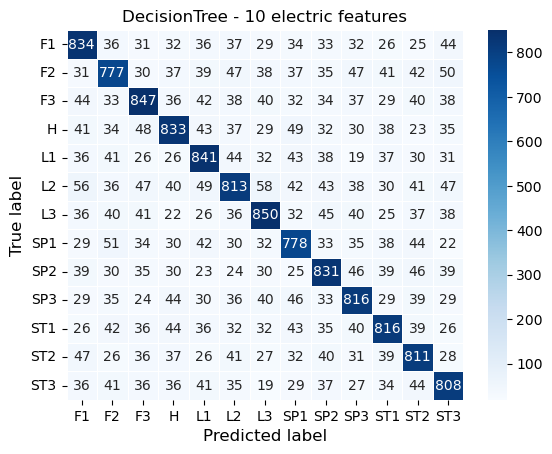

In [38]:
sns.heatmap(cmE, annot=True, xticklabels=classlabels, yticklabels=classlabels, fmt='g', linewidth=.5, cmap=plt.cm.Blues)
plt.yticks(rotation=0)
plt.title("DecisionTree - 10 electric features")
plt.ylabel('True label', fontsize = 12)
plt.xlabel('Predicted label', fontsize = 12)
plt.show()

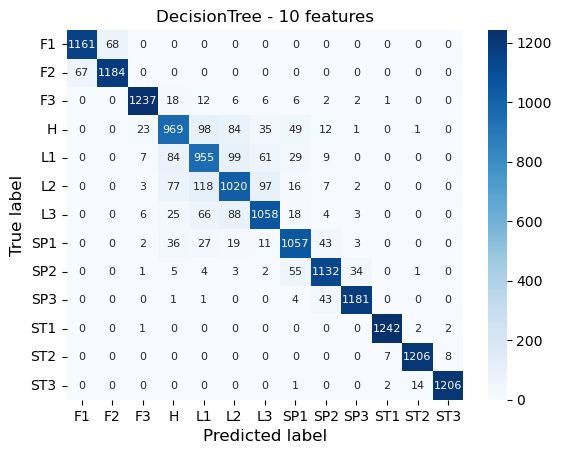

In [39]:
sns.heatmap(cm, annot=True, xticklabels=classlabels, yticklabels=classlabels, fmt='g', linewidth=.001, cmap=plt.cm.Blues, annot_kws={"fontsize":8})
plt.yticks(rotation=0)
plt.title("DecisionTree - 10 features")
plt.ylabel('True label', fontsize = 12)
plt.xlabel('Predicted label', fontsize = 12)
plt.show()

### Comparing results with choosing a variying number of features
In the example, starting with 10 features, the number of features that is chosen is increased by 5 each round until 50 is reached. A DecisionTree classifier is trained with each feature set and the results are saved.

In [41]:
selection_reports = []

num = 10   # How many best features we want to select on first round
intval = 10  # Increase in features chosen

while num <= 50:
    
    selected_features = mrmr_classif(data, Y, K=num)
    selected_data = data[selected_features]
    X_train, X_test, y_train, y_test = train_test_split(selected_data, Y, test_size=0.25,
                                                    shuffle=True, random_state = 8)
    X_train, X_test = scale_data(X_train, X_test)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    p = clf.predict(X_test)
    report = classification_report(y_test, p, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.round(decimals=2)
    
    print("Number of selected features: " + str(num))
    print(selected_features)
    print(df)
    selection_reports.append(df)
    
    num += intval

100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Number of selected features: 10
['RSP minimum', 'AP maximum', 'PSP mean', 'RSP median', 'PSP median', 'PSP sum_of_values', 'RSP mean', 'PSP minimum', 'RSP sum_of_values', 'PSP maximum']
              precision  recall  f1-score  support
0                  0.95    0.94      0.95   1229.0
1                  0.95    0.95      0.95   1251.0
2                  0.97    0.96      0.97   1290.0
3                  0.79    0.76      0.78   1272.0
4                  0.75    0.77      0.76   1244.0
5                  0.77    0.77      0.77   1340.0
6                  0.83    0.83      0.83   1268.0
7                  0.86    0.87      0.87   1198.0
8                  0.90    0.92      0.91   1237.0
9                  0.96    0.96      0.96   1230.0
10                 0.99    1.00      0.99   1247.0
11                 0.99    0.99      0.99   1221.0
12                 0.99    0.99      0.99   1223.0
accuracy           0.90    0.90      0.90      0.9
macro avg          0.90    0.90      0.90  16250.

100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


Number of selected features: 20
['RSP minimum', 'AP maximum', 'PSP mean', 'RSP median', 'PSP median', 'PSP sum_of_values', 'RSP mean', 'PSP minimum', 'RSP sum_of_values', 'PSP maximum', 'AP mean', 'AP median', 'AP minimum', 'AP sum_of_values', 'RSP abs_energy', 'MREF last_location_of_maximum', 'MREF first_location_of_maximum', 'MREF last_location_of_minimum', 'MREF first_location_of_minimum', 'RSP maximum']
              precision  recall  f1-score  support
0                  0.90    0.92      0.91   1229.0
1                  0.92    0.90      0.91   1251.0
2                  0.97    0.97      0.97   1290.0
3                  0.81    0.82      0.82   1272.0
4                  0.77    0.76      0.76   1244.0
5                  0.79    0.79      0.79   1340.0
6                  0.83    0.84      0.83   1268.0
7                  0.85    0.86      0.86   1198.0
8                  0.92    0.90      0.91   1237.0
9                  0.96    0.96      0.96   1230.0
10                 0.99    0

100%|██████████| 30/30 [00:14<00:00,  2.02it/s]


Number of selected features: 30
['RSP minimum', 'AP maximum', 'PSP mean', 'RSP median', 'PSP median', 'PSP sum_of_values', 'RSP mean', 'PSP minimum', 'RSP sum_of_values', 'PSP maximum', 'AP mean', 'AP median', 'AP minimum', 'AP sum_of_values', 'RSP abs_energy', 'MREF last_location_of_maximum', 'MREF first_location_of_maximum', 'MREF last_location_of_minimum', 'MREF first_location_of_minimum', 'RSP maximum', 'PSP abs_energy', 'MREF abs_energy', 'RSP skewness', 'AP abs_energy', 'AP standard_deviation', 'AP kurtosis', 'RSP mean_abs_change', 'RSP abs_sum_of_changes', 'AP mean_abs_change', 'AP abs_sum_of_changes']
              precision  recall  f1-score   support
0                  0.83    0.82      0.82   1229.00
1                  0.82    0.84      0.83   1251.00
2                  0.94    0.93      0.94   1290.00
3                  0.74    0.75      0.75   1272.00
4                  0.59    0.60      0.60   1244.00
5                  0.61    0.60      0.60   1340.00
6                  

100%|██████████| 40/40 [00:18<00:00,  2.12it/s]


Number of selected features: 40
['RSP minimum', 'AP maximum', 'PSP mean', 'RSP median', 'PSP median', 'PSP sum_of_values', 'RSP mean', 'PSP minimum', 'RSP sum_of_values', 'PSP maximum', 'AP mean', 'AP median', 'AP minimum', 'AP sum_of_values', 'RSP abs_energy', 'MREF last_location_of_maximum', 'MREF first_location_of_maximum', 'MREF last_location_of_minimum', 'MREF first_location_of_minimum', 'RSP maximum', 'PSP abs_energy', 'MREF abs_energy', 'RSP skewness', 'AP abs_energy', 'AP standard_deviation', 'AP kurtosis', 'RSP mean_abs_change', 'RSP abs_sum_of_changes', 'AP mean_abs_change', 'AP abs_sum_of_changes', 'AP variance', 'PSP mean_abs_change', 'PSP abs_sum_of_changes', 'AP skewness', 'RSP kurtosis', 'PSP skewness', 'RSP standard_deviation', 'PSP kurtosis', 'MREF mean_abs_change', 'U median']
              precision  recall  f1-score   support
0                  0.79    0.81      0.80   1229.00
1                  0.81    0.79      0.80   1251.00
2                  0.94    0.94      0

100%|██████████| 50/50 [00:20<00:00,  2.38it/s]


Number of selected features: 50
['RSP minimum', 'AP maximum', 'PSP mean', 'RSP median', 'PSP median', 'PSP sum_of_values', 'RSP mean', 'PSP minimum', 'RSP sum_of_values', 'PSP maximum', 'AP mean', 'AP median', 'AP minimum', 'AP sum_of_values', 'RSP abs_energy', 'MREF last_location_of_maximum', 'MREF first_location_of_maximum', 'MREF last_location_of_minimum', 'MREF first_location_of_minimum', 'RSP maximum', 'PSP abs_energy', 'MREF abs_energy', 'RSP skewness', 'AP abs_energy', 'AP standard_deviation', 'AP kurtosis', 'RSP mean_abs_change', 'RSP abs_sum_of_changes', 'AP mean_abs_change', 'AP abs_sum_of_changes', 'AP variance', 'PSP mean_abs_change', 'PSP abs_sum_of_changes', 'AP skewness', 'RSP kurtosis', 'PSP skewness', 'RSP standard_deviation', 'PSP kurtosis', 'MREF mean_abs_change', 'U median', 'MREF kurtosis', 'MREF abs_sum_of_changes', 'U sum_of_values', 'U mean', 'PSP standard_deviation', 'PSP first_location_of_maximum', 'RSP variance', 'RSP first_location_of_maximum', 'W median', '

In [42]:
reports_final_comb = pd.concat(selection_reports, axis=1)

reports_comb = reports_final_comb.filter(like='precision')
reports_comb.columns = ["10", "20", "30", "40", "50"] # column names as the number of features
reports_comb.to_csv(report_path+"/Feature selection comparison.csv", encoding='utf-8-sig')

### Memory profiling
- To compare the memory usage of each classifier during training, memory_profiler is used.
- The memory profiling is done row-by-row, calling the functions for training the classifiers separately.
- The results are saved in text format.
- Install the memory_profiler via pip: pip install -U memory_profiler

In [45]:
import Training_for_memory_profiling as training    # Importing the .py-file with functions to profile
                                                    # Have this in the same location as this code file!

%reload_ext memory_profiler
%mprun -T mprof_DT -c -f training.train_DT training.train_DT(X_train,y_train)
%mprun -T mprof_RF100 -c -f training.train_RF100 training.train_RF100(X_train,y_train)
%mprun -T mprof_SVM -c -f training.train_SVM training.train_SVM(X_train,y_train)
%mprun -T mprof_KNN3 -c -f training.train_KNN training.train_KNN(X_train,y_train)
%mprun -T mprof_SGD -c -f training.train_SGD training.train_SGD(X_train,y_train)
%mprun -T mprof_MLP -c -f training.train_MLP training.train_MLP(X_train,y_train)
%mprun -T mprof_LGBM -c -f training.train_LGBM training.train_LGBM(X_train,y_train)



*** Profile printout saved to text file mprof_DT. 


*** Profile printout saved to text file mprof_RF100. 


*** Profile printout saved to text file mprof_SVM. 


*** Profile printout saved to text file mprof_KNN3. 


*** Profile printout saved to text file mprof_SGD. 


*** Profile printout saved to text file mprof_MLP. 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.034120 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11841
[LightGBM] [Info] Number of data points in the train set: 48750, number of used features: 50
[LightGBM] [Info] Start training from score -2.559365
[LightGBM] [Info] Start training from score -2.565216
[LightGBM] [Info] Start training from score -2.575673
[LightGBM] [Info] Start training from score -2.570833
[LightGBM] [Info] Start training from score -2.563351
[LightGBM] [Info] Start training from score -2.589242
[LightGBM] [Info] Start training from score -2.569761
[Light

Filename: C:\Users\tgdago\Desktop\To Abid\Training_for_memory_profiling.py

Line #    Mem usage    Increment  Occurrences   Line Contents
    38   1373.9 MiB   1373.9 MiB           1   def train_LGBM(X,y):
    39   1373.9 MiB      0.0 MiB           1       clf = LGBMClassifier()
    40   1376.5 MiB      2.6 MiB           1       clf.fit(X,y)